In [1]:
using CSV, DataFrames, Plots

In [2]:
# 物性データをcsvから読み込む
# 2行分は不要なので3行目をヘッダーとして読み込む
properties = CSV.read("properties.csv", DataFrame; header=3)

,WaterCp,WaterRho,AtmosphericPressure
,Int64,Int64,Float64
1,4200,1000,1013.25


In [3]:
# 水の比熱 [J/kg・K]
cp_water = properties[1, :WaterCp]
# 水の密度 [kg/m3]
rho_water = properties[1, :WaterRho]
# 大気圧 [hPa]
air_p = properties[1, :AtmosphericPressure]

1013.25

In [4]:
# 時系列データをcsvから読み込む
sample_data = CSV.read("water_air_data.csv", DataFrame)

,Time,FlowRate,InletTemperature,OutletTemperature,AirTemperature,RelativeHumidity
,Int64,Float64,Float64,Float64,Float64,Float64
1,0,41.6485,25.1724,29.7713,29.8,82.7
2,10,40.5922,25.6032,30.2638,29.8,84.6
3,20,43.1063,25.5635,28.9655,30.4,84.3
4,30,42.6069,25.1515,27.5197,30.0,85.5
5,40,43.8942,25.0849,28.2331,29.8,81.3
6,50,43.7551,25.3595,27.4537,30.6,84.8
7,60,43.1546,25.5934,28.5807,30.4,85.0
8,70,41.4452,25.8141,28.9785,30.3,83.2
9,80,42.1474,25.2231,27.464,30.7,83.9


In [5]:
# 経過時間 [s]
time = sample_data[:, :Time]
# 冷却水流量 [L/min]
flow_rate = sample_data[:, :FlowRate]
# 冷却水入り温度 [℃]
inlet_temp = sample_data[:, :InletTemperature]
# 冷却水戻り温度 [℃]
outlet_temp = sample_data[:, :OutletTemperature]
# 気温 [℃]
air_temp = sample_data[:, :AirTemperature]
# 相対湿度 [%]
relative_humidity = sample_data[:, :RelativeHumidity]

999-element Vector{Float64}:
 82.7
 84.6
 84.3
 85.5
 81.3
 84.8
 85.0
 83.2
 83.9
 84.3
 83.8
 85.1
 82.4
  ⋮
 85.5
 83.0
 85.1
 85.5
 84.4
 82.6
 80.8
 83.3
 82.5
 81.7
 84.4
 80.8

In [6]:
# 行数取得
num_rows = nrow(sample_data)
# 列数取得
num_columns = ncol(sample_data)
# 行数と同じ要素数の配列を用意
# 冷却水による脱熱量
heat_loss = [Float64(1.0) for i in 1:num_rows]
# 容積絶対湿度 [g/m3]
volumetric_humidity = [Float64(1.0) for i in 1:num_rows]
# 重量絶対湿度 [kg/kg(DA)]
mixing_ratio = [Float64(1.0) for i in 1:num_rows]

# for loopの時間を計測
@time for i = 1:num_rows
    # 冷却水の出入りの温度差
    del_temp = outlet_temp[i] - inlet_temp[i]
    # 冷却水の脱熱量
    heat_loss[i] = flow_rate[i] / 1000 / 60 * cp_water * rho_water * del_temp # [W]
    # 飽和水蒸気圧 [hPa]
    es = 6.11 * 10 ^ (7.5 * air_temp[i] / (237.3 + air_temp[i]))
    # 水蒸気分圧 [hPa]
    e = es * relative_humidity[i] / 100
    volumetric_humidity[i] = 217 * e / (273.15 + air_temp[i])
    mixing_ratio[i] = 0.62198 * e / (air_p - e)
end
# 元データの配列に列追加、列名変更
array1 = rename(hcat(sample_data, heat_loss), :x1 => :HeatLoss)
array2 = rename(hcat(array1, volumetric_humidity), :x1 => :VolumetricHumidity)
array3 = rename(hcat(array2, mixing_ratio), :x1 => :MixingRatio)
# CSVに書き込み
CSV.write("./sample_output_rows$num_rows.csv", array3)

  0.030471 seconds (37.06 k allocations: 1.081 MiB, 96.67% compilation time)


"./sample_output_rows999.csv"

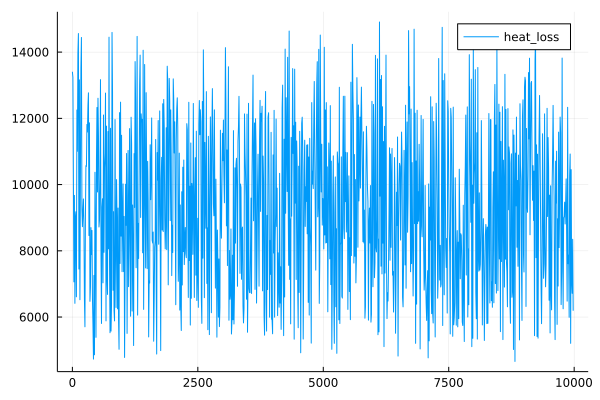

In [7]:
gr()
# @TODO X軸Y軸などの情報追加https://qiita.com/I_ppp/items/dca3552affa6a672e4bd
plot(time, heat_loss,
    label = "heat_loss"
)

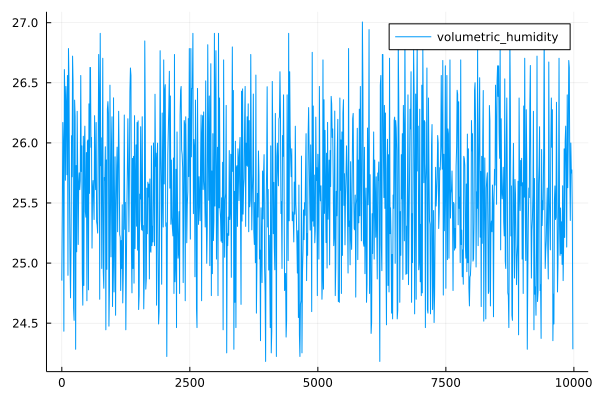

In [8]:
plot(time, volumetric_humidity,
    label = "volumetric_humidity"
)

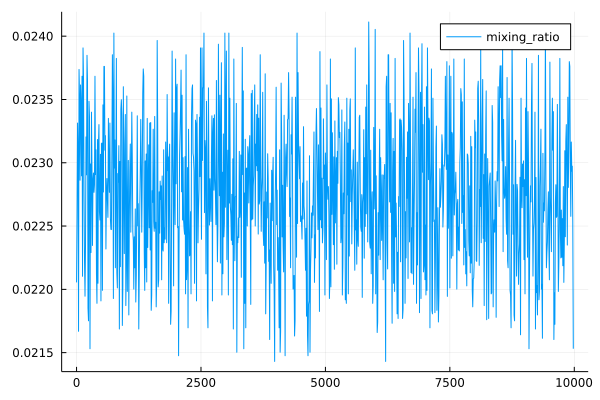

In [9]:
plot(time, mixing_ratio,
    label = "mixing_ratio"
)